# Stock Price predictor

### Packages

- numpy : to work with arrays.
- pandas : to work with dataframes.
- matplotlib : to plot graphs.
- tensorflow : to work with neural networks.
- Yahoo Finance : API to extract stock data.
- datetime : to calculate time to get data.
- sklearn : to use ML algorithms.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import yfinance as yf
import datetime as dt

%matplotlib inline

### Downloading data

Used Yahoo Finance API to collect data of Microsoft stock price for 20+ years.

In [33]:
# end and start time
end = dt.datetime.now() # current time
start = dt.datetime(end.year - 23, end.month, end.day) #start time = current time - 23 years

#downloading MSFT data from start to end
stock_data = yf.download("MSFT", start, end)

print(stock_data)

[*********************100%***********************]  1 of 1 completed
                                 Open        High         Low       Close  \
Date                                                                        
1999-10-11 00:00:00-04:00   47.312500   47.500000   47.062500   47.156250   
1999-10-12 00:00:00-04:00   47.000000   47.156250   46.187500   46.281250   
1999-10-13 00:00:00-04:00   46.000000   46.562500   45.156250   45.531250   
1999-10-14 00:00:00-04:00   45.437500   46.117188   44.843750   45.343750   
1999-10-15 00:00:00-04:00   44.750000   44.906250   43.656250   44.031250   
...                               ...         ...         ...         ...   
2022-10-03 00:00:00-04:00  235.410004  241.610001  234.660004  240.740005   
2022-10-04 00:00:00-04:00  245.089996  250.360001  244.979996  248.880005   
2022-10-05 00:00:00-04:00  245.990005  250.580002  244.100006  249.199997   
2022-10-06 00:00:00-04:00  247.929993  250.339996  246.080002  246.789993   
2022-10

### Plotting the data


x - axis : Year.
<br>
y - axis : Close price.

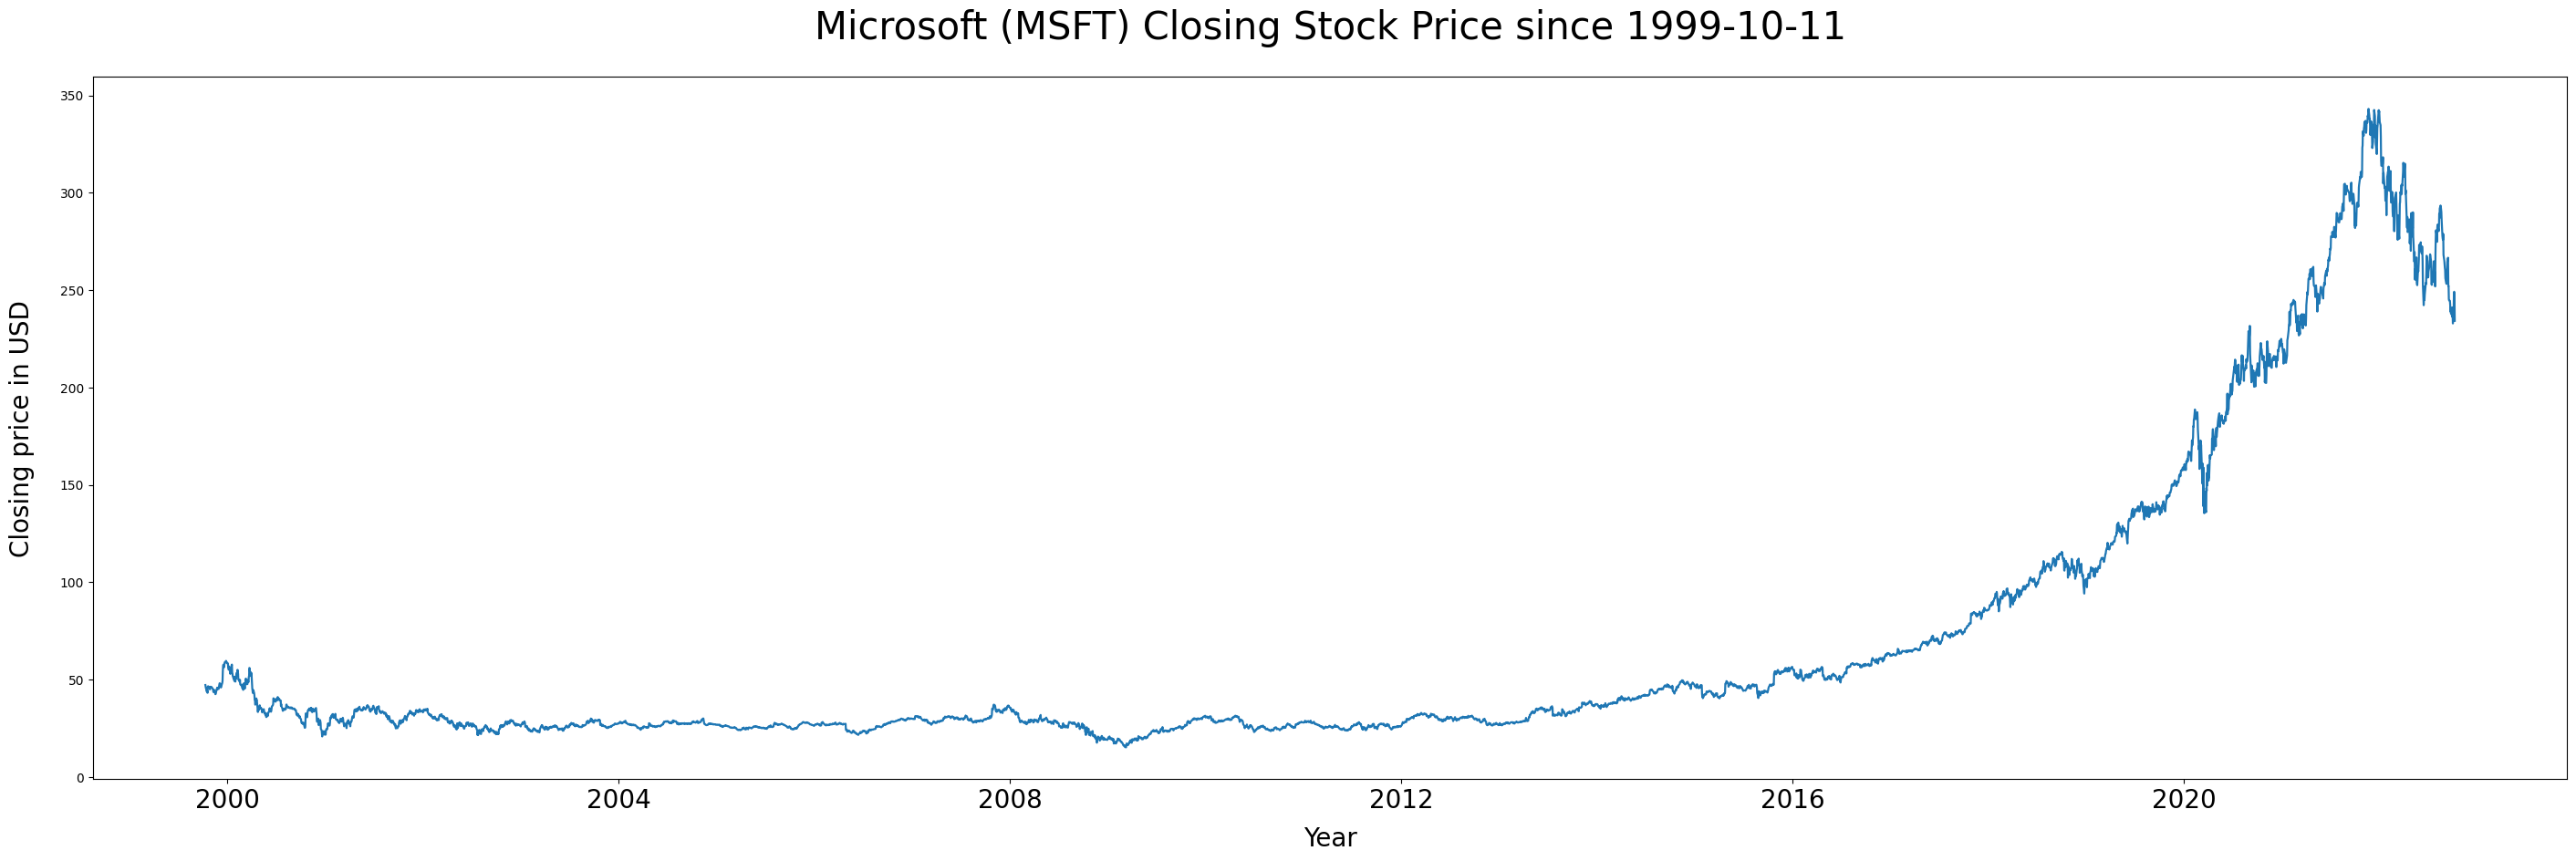

In [25]:
plt.figure(figsize=(35, 10))
plt.plot(stock_data["Close"], linewidth = 1.6)
plt.xlabel("Year", fontsize = 20, labelpad = 10)
plt.xticks(fontsize = 20)
plt.ylabel("Closing price in USD", fontsize = 20, labelpad = 20)
plt.title("Microsoft (MSFT) Closing Stock Price since 1999-10-11", fontsize = 30, pad = 30)

plt.show()

### Normalizing the data

Normalizing the collected data in (0, 1) range. This makes gradient descent run faster.

In [34]:
# creating a dataframe with just the Close data
stock_prices = stock_data.filter(["Close"])

# converting pandas dataframe to numpy array
dataset = stock_prices.values

print(f"Close price Pre-Normalization =\n {dataset[:5]}")

# normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(stock_prices.values)

print(f"Close price Post-Normalization =\n {normalized_dataset[:5]}")

Close price Pre-Normalization =
 [[47.15625]
 [46.28125]
 [45.53125]
 [45.34375]
 [44.03125]]
Close price Post-Normalization =
 [[0.09759194]
 [0.09492393]
 [0.09263706]
 [0.09206535]
 [0.08806334]]


### Splitting data to training and test set

70% of the data for training and 30% for testing to evaluate the performance of our model.

In [35]:
# calculating number of training examples
train_examples = int(np.ceil(normalized_dataset.shape[0] * .7))

# splitting into training and test set
train = normalized_dataset[:train_examples, :]
test = normalized_dataset[train_examples - 29:, :]

print(f"Training set shape =\n {train.shape}")
print(f"Test set shape =\n {test.shape}")

Training set shape =
 (4051, 1)
Test set shape =
 (1765, 1)


### Splitting training data into features and targets

X_train is the feature array, and y_train is target array.

- The model will learn from the closing stock price data of 29 consecutive days and predict the price on 30th day.
- X_train is thus a 3D array of shape (l, m, n), where l = number of training examples, m = 29 (number of days), n = 1 (only 1 feature).

In [36]:
# creating empty arrays
X_train, y_train = [], []

# appending price on every 29 days to X_train and the 30th day to y_train
for i in range(29, len(train)):
    X_train.append(train[i - 29 : i, 0])
    y_train.append(train[i, 0])

# converting to numpy array and reshaping it to a 3D array
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


print(f"X_train shape = {X_train.shape}, y_train shape = {y_train.shape}\n")
print(f"X_train =\n {X_train}")
print(f"y_train =\n {y_train}")

X_train shape = (4022, 29, 1), y_train shape = (4022,)

X_train =
 [[[0.09759194]
  [0.09492393]
  [0.09263706]
  ...
  [0.0869199 ]
  [0.08339432]
  [0.08329904]]

 [[0.09492393]
  [0.09263706]
  [0.09206535]
  ...
  [0.08339432]
  [0.08329904]
  [0.0849189 ]]

 [[0.09263706]
  [0.09206535]
  [0.08806334]
  ...
  [0.08329904]
  [0.0849189 ]
  [0.09073134]]

 ...

 [[0.08982803]
  [0.09275522]
  [0.09598732]
  ...
  [0.12126479]
  [0.11894744]
  [0.11696548]]

 [[0.09275522]
  [0.09598732]
  [0.09635322]
  ...
  [0.11894744]
  [0.11696548]
  [0.11739238]]

 [[0.09598732]
  [0.09635322]
  [0.09650567]
  ...
  [0.11696548]
  [0.11739238]
  [0.11638615]]]
y_train =
 [0.0849189  0.09073134 0.09044549 ... 0.11739238 0.11638615 0.11492256]


### Creating the Model

Creating a Sequential model with 1 input layer, 3 hidden layers and 1 output layer.

- Input layer accepts numpy arrays of shape (m, n), where m = 29 (number of days), n = 1 (only 1 feature).
- 2 LSTM layers with tanh activation function and 150, 70 units respectively to reduce overfitting.
- 1 Dense layer with 20 units and relu activation function.
- Output layer with relu activation function.

Compiling the model with Huber loss function and Adam Gradient Descent with a learning rate of 0.002.

Training the model with 10 epochs.

In [38]:
tf.random.set_seed(1234)
model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape = (X_train.shape[1],1)),
        tf.keras.layers.LSTM(units = 150, return_sequences = True, activation = "tanh"),
        tf.keras.layers.LSTM(units = 70, return_sequences = False, activation = "tanh"),
        tf.keras.layers.Dense(units = 20, activation = "relu"),
        tf.keras.layers.Dense(units = 1, activation = "relu")
    ]
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002)
)

model.fit(
    X_train, y_train,
    epochs = 10
)

Epoch 1/10
126/126 [==============================] - 8s 39ms/step - loss: 2.9167e-05
Epoch 2/10
126/126 [==============================] - 5s 40ms/step - loss: 8.8985e-06
Epoch 3/10
126/126 [==============================] - 5s 39ms/step - loss: 7.2463e-06
Epoch 4/10
126/126 [==============================] - 5s 39ms/step - loss: 7.1951e-06
Epoch 5/10
126/126 [==============================] - 5s 40ms/step - loss: 6.6724e-06
Epoch 6/10
126/126 [==============================] - 5s 39ms/step - loss: 5.2853e-06
Epoch 7/10
126/126 [==============================] - 5s 39ms/step - loss: 5.5263e-06
Epoch 8/10
126/126 [==============================] - 5s 40ms/step - loss: 4.9586e-06
Epoch 9/10
126/126 [==============================] - 5s 40ms/step - loss: 4.5428e-06
Epoch 10/10
126/126 [==============================] - 5s 40ms/step - loss: 4.0574e-06


### Splitting test data into features and targets

X_test is the feature array, and y_test is target array.

- Similar to X_train, X_test is a 3D array of shape (l, m, n), where l = number of training examples, m = 29 (number of days), n = 1 (only 1 feature).

In [47]:
# creating empty arrays
X_test, y_test = [], []

# appending price on every 29 days to X_test and the 30th day to y_test
for i in range(29, len(test)):
    X_test.append(test[i - 29 : i, 0])
    y_test.append(test[i, 0])

# converting to numpy array and reshaping it to a 3D array
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


print(f"X_test shape = {X_test.shape}, y_test shape = {y_test.shape}\n")
print(f"X_test =\n {X_test}")
print(f"y_test =\n {y_test}")

X_test shape = (1736, 29, 1), y_test shape = (1736,)

X_test =
 [[[0.09635322]
  [0.09650567]
  [0.09848763]
  ...
  [0.11739238]
  [0.11638615]
  [0.11492256]]

 [[0.09650567]
  [0.09848763]
  [0.09745092]
  ...
  [0.11638615]
  [0.11492256]
  [0.11775827]]

 [[0.09848763]
  [0.09745092]
  [0.09711551]
  ...
  [0.11492256]
  [0.11775827]
  [0.11531895]]

 ...

 [[0.79473113]
  [0.80406153]
  [0.77125262]
  ...
  [0.66395293]
  [0.68785832]
  [0.71267842]]

 [[0.80406153]
  [0.77125262]
  [0.76253208]
  ...
  [0.68785832]
  [0.71267842]
  [0.71365413]]

 [[0.77125262]
  [0.76253208]
  [0.75564097]
  ...
  [0.71267842]
  [0.71365413]
  [0.70630566]]]
y_test =
 [0.11775827 0.11531895 0.1180022  ... 0.71365413 0.70630566 0.66803883]


### Prediction

Using our model to make predictions on test data and de-normalizing the predictions.

In [48]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(predictions.shape)

55/55 [==============================] - 1s 10ms/step


### Evaluating the model

Using 2 metrics to evaluate the performance of our model on new unseen data.

- **Mean Absolute Error** : Evaluates an average of how far away are the predictions from actual targets.
- **Mean Absolute Percentage Error** : Evaluates the percentage of how far are the predictions from the actual targets as a fraction of the actual targets.

In [49]:
# converting normalized targets back to original form
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(predictions, y_test)
mape = mean_absolute_percentage_error(predictions, y_test)
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")

Mean Absolute Error = 2.750564179662186
Mean Squred Error = 16.121499522375366
Mean Absolute Percentage Error = 0.018334989799206575%


### Plotting the predictions

Plotting the predictions along with training and test data to visualize the performance of our model.

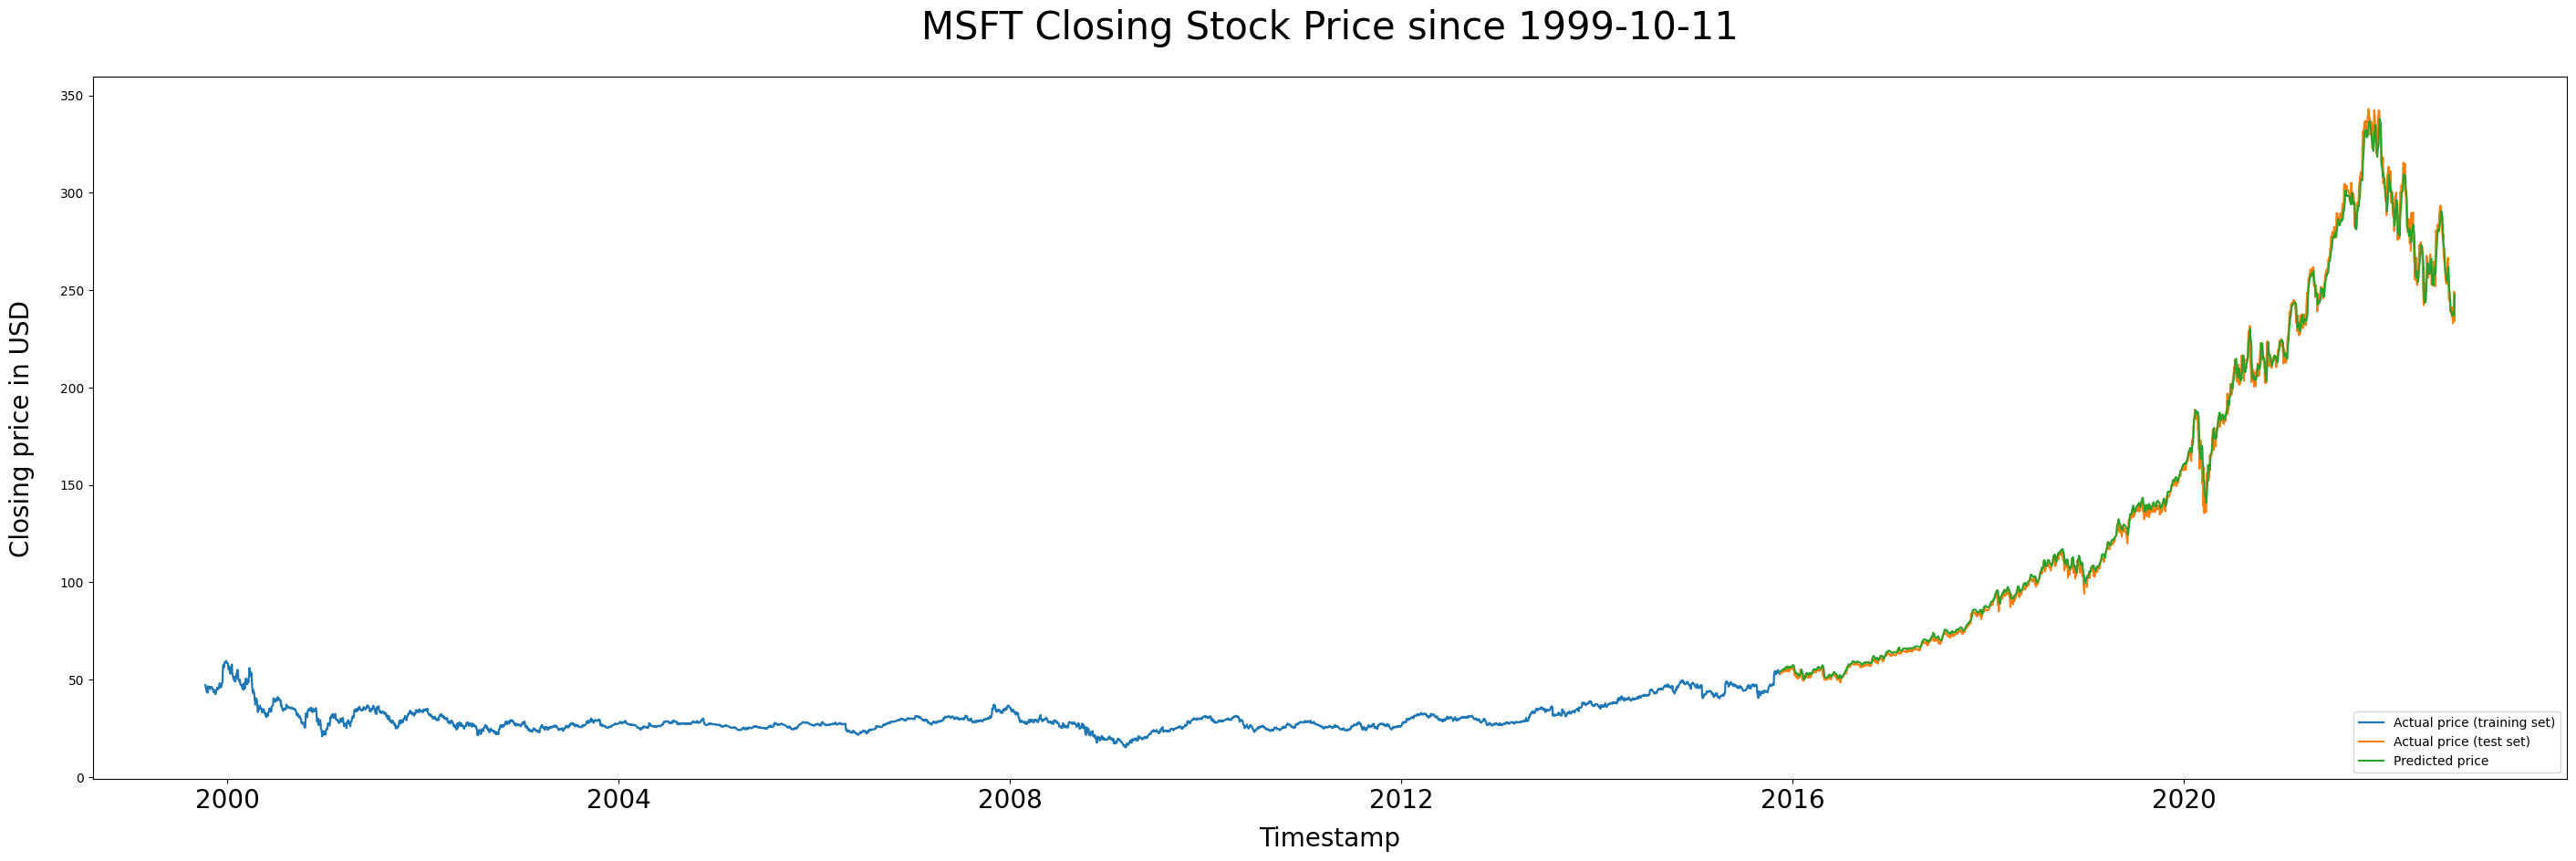

In [41]:
pd.options.mode.chained_assignment = None

train = stock_prices[:train_examples]
true = stock_prices[train_examples:]
true["Predictions"] = predictions

plt.figure(figsize=(35, 10))

plt.plot(train["Close"], linewidth = 1.6)
plt.plot(true[['Close', 'Predictions']])

plt.xlabel("Timestamp", fontsize = 20, labelpad = 10)
plt.xticks(fontsize = 20)
plt.ylabel("Closing price in USD", fontsize = 20, labelpad = 20)
plt.title("MSFT Closing Stock Price since 1999-10-11", fontsize = 30, pad = 30)
plt.legend(['Actual price (training set)', 'Actual price (test set)', 'Predicted price'], loc='lower right')

plt.show()

### Saving the model

Saving the weights and the trained model for future inferencing.

In [17]:
model.save_weights("stock_prediction_weights.h5")
model.save("stock_prediction_model.h5")